# Directional Armoring Summarization

Errata: -9999 appearing in mitigation quality lookup, although not in orginal mitigation file.  Not used in Dave's spreadsheet, so shouldn't affect final results.  

Total Acres column is not reliable/used, please ignore.

In this approach to incidental take, lines representing potential armoring structure centerlines were oriented uniformly so that their righthand side was seaward.  They were then buffered directionally by 100m on each side, to represent the maximum likely extent of habitat inside FBHCP R-zones.   Then they were intersected with FNAI's mapped habitat polygons for each bird species group and for sea turtles.

This process created a set of intermediate files which are the inputs to this script.

### Required Input Resources

In [137]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import numpy as np

In [138]:
path = 'intermediates' # all inputs are intermediate files produced by a prior GIS process
report_path = 'outputs'  # put results into an output directory parallel to this notebook

In [166]:
# future armoring in 
fut_arm_st_shp = 'future_armoring_directional_take_seaturtles_w_regions.shp'
fut_arm_solo_shp = 'future_armoring_directional_take_solitary_shorebirds_by_region.shp'
fut_arm_colo_shp = 'future_armoring_directional_take_colonial_shorebirds_by_region.shp'
fut_arm_nbsb_shp = 'future_armoring_directional_take_nonbreeding_shorebirds_w_regions.shp'

gap_arm_st_shp = 'gap_armoring_seaturtle_impacts_v2.shp'
gap_arm_snsb_shp = 'gap_armoring_solitary_nester_impacts.shp'
gap_arm_colo_shp = 'gap_armoring_colonial_nesters_impacts.shp'
gap_arm_nbsb_shp = 'gap_armoring_nonbreeding_shorebird_impacts.shp'

rzone_shp = 'management_protection_by_rzone_w_regions.shp'

#### Optional utility to move multi-part shapefiles

In [182]:
def copy_shapefile(oldpath, newpath):
    required_count = 3
    actual_count = 0
    cwd = %pwd

    oldbase = os.path.basename(oldpath).replace('.shp','')
    #print('oldbase is {}'.format(oldbase))
    oldpath = oldpath.replace(os.path.basename(oldpath), '')
    #print('oldpath is {}'.format(oldpath))
    #if path isn't absolute, starting with a slash, then treat as relative to pwd
    if newpath[1] != '/':
        newpath = os.path.join(cwd, newpath)
    #print('newpath is {}'.format(newpath))
    required_parts = ('shp', 'shx', 'dbf')
    optional_parts = ('prj', 'sbx', 'sbn')
    
    for p in required_parts:
        oldfile = os.path.join(oldpath, '{}.{}'.format(oldbase, p))
        newfile = os.path.join(newpath, '{}.{}'.format(oldbase, p))
        try:
            !cp {oldfile} {newfile}
        except:
            print('Could not copy required shapefile part "{}"'.format(oldfile))
        actual_count += 1

    for p in optional_parts:
        oldfile = os.path.join(oldpath, '{}.{}'.format(oldbase, p))
        newfile = os.path.join(newpath, '{}.{}'.format(oldbase, p))
        if os.path.exists(oldfile):
            !cp {oldfile} {newfile}
    if actual_count == required_count:
        print('Successfully found and copied required elements')

mit_file = '/Users/mflaxman/Dropbox/fbhcp/it4/mitigation.shp'


copy_shapefile(mit_file, 'intermediates')

Successfully found and copied required elements


#### Check the all files are in place and readable

In [141]:
import os

missing = 0
for sp in ('st', 'snsb', 'colo', 'nbsb'):
    fut_file_var = 'fut_arm_{}_shp'.format(sp)
    gap_file_var = 'gap_arm_{}_shp'.format(sp)

    fut_filepath = os.path.join(path, eval(fut_file_var))
    if not os.path.exists(fut_filepath):
        print("Setup error, could not find required future armoring file: {}".format(fut_file_var))
        missing += 1
    gap_filepath = os.path.join(path, eval(gap_file_var))
    if not os.path.exists(gap_filepath):
        print("Setup error, could not find required gap armoring file: {}".format(gap_file_var))
        missing += 1
      
if missing == 0:
    print('Found all future armoring files')

Found all future armoring files


In [142]:
rzones = gpd.read_file(os.path.join(path,rzone_shp))
rzones.head(1)

,OBJECTID,FIPSSTCO,STATE,COUNTY,UNIQUE_ID,MONUMENT_N,RANGE,RMon_ID,aug2012_me,aug2016_me,PcntDelta,abs_dif,prot_sum,prot_count,prot_mean,FBHCP_Regn,geometry
0,59,12089,Florida,Nassau,NA R-059,R-059,R,68,0.668131,1.498814,19.13,0,0.0,179.0,0.0,Northeast,"POLYGON ((644927.937400002 731385.060000007, 6..."


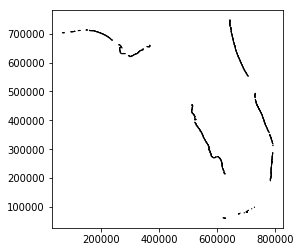

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
#scheme='quantiles', 
rzones.plot(column='aug2016_me', cmap='OrRd', edgecolor='Black')

#### Optional Visualization Using Mapbox-gl library

Set a  MAPBOX_ACCESS_TOKEN environment variable or copy/paste your token from https://www.mapbox.com/studio/account/tokens/

In [97]:
try:
    from mapboxgl.viz import *
    from mapboxgl.utils import *
    import pysal.esda.mapclassify as mapclassify

except:
    print("Problem importing Mapbox-gl or pysal libraries")
    
# Must be a public token, starting with `pk`
token = os.getenv('MAPBOX_ACCESS_TOKEN')
if token == None or token[0:2] != 'pk':
    print("Problem getting public mapbox access token, check environment variables setup")

Problem getting public mapbox access token, check environment variables setup


In [81]:
# mapbox-gl wants a geojson file on disk...
geojson_file = 'rzones.geojson'
if not os.path.exists(geojson_file):
    rzones.to_crs('+init=epsg:4326').to_file(filename=geojson_file, driver="GeoJSON")
else:
    print('Using prior geojson file from disk, remove if that is not what you want!')

Using prior geojson file from disk, remove if that is not what you want!


In [82]:
# Generate data breaks and color stops from colorBrewer
color_breaks = mapclassify.Natural_Breaks(rzones['aug2016_me'], k=8, initial=0).bins
color_breaks

array([ 1.34027135,  3.48806281,  6.79536104, 11.71605968, 18.58909668,
       28.70648845, 46.13581035, 83.30645879])

In [83]:
try:
    import mapboxgl.utils as u
except:
    print('Import problem')
    
color_stops = u.create_color_stops(color_breaks, colors='YlGnBu')

In [84]:
# Radius stops for linear interpolation
lighting_radius_stops = [
    [0.0, 10.0],
    [5.0, 12.0],
    [10.0, 14.0],
    [25.0, 16.0],
    [50.0, 18.0],
    [100.0, 20.0],   
]

# Create the viz from the dataframe
viz = CircleViz('rzones.geojson',
                access_token=token, 
                height='400px',
                color_property = "aug2016_me",
                color_stops = color_stops,
                center = (-81.442263832474609, 30.559170717501537),
                zoom = 8,
                below_layer = 'waterway-label'
                )

viz.radius_property = 'aug2016_me'
viz.radius_type = 'exponential'
viz.radius_stops = lighting_radius_stops
viz.show()

In [85]:
# create choropleth from polygon features stored as GeoJSON
# line_color='rgb(128,0,38)',
viz = ChoroplethViz('rzones.geojson', 
                     color_property='aug2016_me',
                     color_stops=color_stops,
                     color_function_type='interpolate',
                     line_stroke='--',
                     opacity=0.8,
                     center=(-81.442263832474609, 30.559170717501537),
                     zoom=6,
                     below_layer='waterway-label'
                    )

viz.line_width_stops=create_numeric_stops([0, 5, 10, 25, 100], 0.1, 6)
viz.line_width_property='aug2016_me'
viz.line_width_function_type='interpolate'
viz.line_width_default='1'


viz.show()

#### Clean up intermediate shapefile columns

In [144]:
# this is challengingly byzantine...
# try to keep the left if needed, and keep and rename right below
potentialDrops = ['FBHCP_Regn_right','aug2012_me', 'aug2016_me', 'PcntDelta', 'abs_dif', \
                 'prot_min', 'prot_max', 'prot_sum', 'prot_count','prot_mean','prot_std','prot_uniqu', \
                 'NoWrack15', 'Disturb15', 'Tracks15', 'Unposted15', \
                 'COUNTY_left','COUNTYFP', \
                 'Hectares', 'RMon_ID', \
                 'RANGE', 'STATE', 'MONUMENT_N', 'index_right', \
                 'FIPSSTCO',  'OBJECTID', \
                 'COMMENTS', 'ImpactType', 'DATE_', 'ORGINATOR', \
                 'Coast', 'Shape_Leng', 'Shape_Area', 'SPE_GROUP', \
                 'MONUMENT_N_left', 'MONUMENT_N_right', 'FIPSSTCO_left','FIPSSTCO_right', \
                 'UNIQUE_ID_right', 'FBHCP_Regn_2', 'COUNTY_2']
#'Side','side',
def cleanFrame(df):
    cols = df.columns
    for d in potentialDrops:
        if d in cols:
            df = df.drop(d, axis=1)
    return df # cleaned up copy

In [145]:
def renameColumns(df):
    df = df.rename(columns={'FBHCP_Regn_left': 'Region', \
                        'FBHCP_Regn': 'Region', \
                        'DirectAc': 'Direct Take Acres', \
                        'IndirectAc': 'Indirect Take Acres', \
                        'Acres': 'Total Acres', \
                        'UNIQUE_ID': 'R-Zone', \
                        'UNIQUE_ID_left': 'R-Zone', \
                        'COUNTY_right': 'County', \
                        'COUNTY': 'County', \
                        'Spp_Group': 'Species', \
                        'side': 'Side'})
    return(df)

In [168]:
import  numpy as np
cwd = %pwd
basepath = os.path.join(cwd, path)

sp = ('st','solo','colo','nbsb')
sp = ('solo',)

# empty master cross-species report for appending
all_arm_impacts_all_species_by_rzone = None

for s in sp:
    print('\n\nWorking on {}'.format(s))
    fut_file_var = 'fut_arm_{}_shp'.format(s)
    gap_file_var = 'gap_arm_{}_shp'.format(s)

    
    fut_filepath = os.path.join(basepath, eval(fut_file_var))
    gap_filepath = os.path.join(basepath, eval(gap_file_var))
        
    try:
        print('Reading {}'.format(fut_filepath))
        fut_arm_impacts = gpd.read_file(fut_filepath).to_crs(rzones.crs)
        rows = fut_arm_impacts_by_rzone.shape[0]
        print('Found {} rows'.format(rows))
    except:
        raise ValueError("Problem reading future armoring impacts file '{}'".format(fut_filepath))

    try:
        print('Performing spatial join of future armoring impacts and rzones for species {}'.format(s))
        fut_arm_impacts_by_rzone = gpd.overlay(fut_arm_impacts, rzones, how='intersection')
    except:
        raise ValueError('Problem performing spatial join')
    
    try:
        # create Direct/Indirect flag field based on side
        fut_arm_impacts_by_rzone['Activity'] = 'Armoring'
        fut_arm_impacts_by_rzone['Type'] = 'Future Armoring'
        fut_arm_impacts_by_rzone = renameColumns(fut_arm_impacts_by_rzone)
        fut_arm_impacts_by_rzone = cleanFrame(fut_arm_impacts_by_rzone)
        print('Future armoring impact columns follow for species {}'.format(s))
        print(fut_arm_impacts_by_rzone.columns)        
    except:
        raise ValueError('Problem cleaning up future armoring')
    print('Future armoring after intersect has {} rows'.format(fut_arm_impacts_by_rzone.shape[0]))
    fut_arm_impacts_by_rzone.head()
    # update impact areas here, since r-zone intersection alters geographies
    try:
        fut_arm_impacts_by_rzone['Total Acres'] = (fut_arm_impacts_by_rzone['geometry'].area/ 10**4) * 2.54
        fut_arm_impacts_by_rzone['Direct Take Acres'] =  np.where(fut_arm_impacts_by_rzone['Side'] == 'Landward', fut_arm_impacts_by_rzone['Total Acres'], 0.0)
        fut_arm_impacts_by_rzone['Indirect Take Acres'] =  np.where(fut_arm_impacts_by_rzone['Side'] == 'Seaward', fut_arm_impacts_by_rzone['Total Acres'], 0.0)

    except:
        raise ValueError("Problem computing areas of impacts columns")

    try:
        gap_arm_impacts = gpd.read_file(gap_filepath).to_crs(rzones.crs)
        print('Performing spatial join of gap armoring impacts and rzones for species {}'.format(s))
        gap_arm_impacts_by_rzone = gpd.overlay(fut_arm_impacts, rzones, how='intersection')

        gap_arm_impacts_by_rzone['Activity'] = 'Armoring'
        gap_arm_impacts_by_rzone['Type'] = 'Gap Armoring'
        gap_arm_impacts_by_rzone = renameColumns(gap_arm_impacts_by_rzone)
        gap_arm_impacts_by_rzone = cleanFrame(gap_arm_impacts_by_rzone)
        #print('Gap armoring impact columns follow for species {}'.format(species))
        #print(gap_arm_impacts_by_rzone.columns)
    except:
        raise ValueError('Problem reading or cleaning gap armoring')
        
    # update impact areas here, since r-zone intersection alters geographies

    try:
        gap_arm_impacts_by_rzone['Total Acres'] = (gap_arm_impacts_by_rzone['geometry'].area/ 10**4) * 2.54
        gap_arm_impacts_by_rzone['Direct Take Acres'] = np.where(gap_arm_impacts_by_rzone['Side'] == 'Landward', gap_arm_impacts_by_rzone['Total Acres'], 0.0)
        gap_arm_impacts_by_rzone['Indirect Take Acres'] = np.where(gap_arm_impacts_by_rzone['Side'] == 'Seaward',gap_arm_impacts_by_rzone['Total Acres'], 0.0)

    except:
        raise ValueError("Problem recomputing acreage of gap armoring impacts '{}'".format(fut_file_var))


    fut_arm_impacts_by_rzone_report = fut_arm_impacts_by_rzone.pivot_table(index=['Region','County','R-Zone','Species','Type'], values=['Total Acres','Indirect Take Acres','Direct Take Acres'],
                                   aggfunc=np.sum).round(1)
    outfile = os.path.join(report_path, 'fbhcp_chp8_fut_arm_{}_take_by_rzone.xls'.format(species))
    fut_arm_impacts_by_rzone_report.to_excel(outfile)

    fut_arm_impacts_by_region_report = fut_arm_impacts_by_rzone.pivot_table(index=['Region','Type'], values=['Total Acres','Indirect Take Acres','Direct Take Acres'],
                                   aggfunc=np.sum).round(1)
    #fut_arm_impacts_by_region_report
    
    outfile = os.path.join(report_path, 'fbhcp_chp8_fut_arm_{}_take_by_region.xls'.format(species))
    fut_arm_impacts_by_region_report.to_excel(outfile)
    

    gap_arm_impacts_by_rzone_report = gap_arm_impacts_by_rzone.pivot_table(index=['Region','County','R-Zone','Species','Type'], values=['Total Acres','Indirect Take Acres','Direct Take Acres'],
                               aggfunc=np.sum).round(1)
    outfile = os.path.join(report_path, 'fbhcp_chp8_gap_arm_{}_take_by_rzone.xls'.format(species))
    gap_arm_impacts_by_rzone_report.to_excel(outfile)

    gap_arm_impacts_by_region_report = gap_arm_impacts_by_rzone.pivot_table(index=['Region','Type'], values=['Total Acres','Indirect Take Acres','Direct Take Acres'],
                               aggfunc=np.sum, margins=True).round(1)
    #gap_arm_impacts_by_region_report
    outfile = os.path.join(report_path, 'fbhcp_chp8_gap_arm_{}_take_by_region.xls'.format(species))
    gap_arm_impacts_by_region_report.to_excel(outfile)

    print('Generating combined future and gap armoring reports for species {}'.format(species))
    all_arm_impacts_by_region = fut_arm_impacts_by_region_report.append(gap_arm_impacts_by_region_report)
    all_arm_impacts_by_region = renameColumns(all_arm_impacts_by_region)
    all_arm_impacts_by_region = cleanFrame(all_arm_impacts_by_region)
    #print('All armoring impact columns follow for species {}'.format(species))
    #print(all_arm_impacts_by_region.columns)
    #print(all_arm_impacts_by_region.head())

    all_arm_impacts_by_region_report = all_arm_impacts_by_region.pivot_table(index=['Region'], values=['Total Acres','Indirect Take Acres','Direct Take Acres'],
                               aggfunc=np.sum).round(1)
    outfile = os.path.join(report_path, 'fbhcp_chp8_arm_{}_take_by_region.xls'.format(species))
    all_arm_impacts_by_region_report.to_excel(outfile)
    print('Combined report for species {} exported to excel file "{}"'.format(species, outfile))
    
    all_arm_impacts_by_rzone = fut_arm_impacts_by_rzone_report.append(gap_arm_impacts_by_rzone_report)
    all_arm_impacts_by_rzone = renameColumns(all_arm_impacts_by_rzone)
    all_arm_impacts_by_rzone = cleanFrame(all_arm_impacts_by_rzone)
    #impacts['File'] = 'Upland June 27 2018'
    #qa_take_by_rzone_report = impacts.pivot_table(index=['File','R-zone','FBHCP_Regn','activity','species','quality'], values=['Ac Direct','Ac Indirect','QA Direct','QA Indirect'],
    #                           aggfunc=np.sum, margins=True, fill_value=0).round(2)

    all_arm_impacts_by_rzone['File'] = 'Armoring June 27 2018'
    all_arm_impacts_by_rzone['Activity'] = 'Armoring'
    
    all_arm_impacts_by_rzone_report = all_arm_impacts_by_rzone.pivot_table(index=['File','R-Zone','Region','Activity','Species','County'], values=['Total Acres','Indirect Take Acres','Direct Take Acres'],
                               aggfunc=np.sum).round(1)
    outfile = os.path.join(report_path, 'fbhcp_chp8_arm_{}_take_by_rzone.xls'.format(species))
    all_arm_impacts_by_rzone_report.to_excel(outfile)

    if all_arm_impacts_all_species_by_rzone is None:
        print('Generating initial all species report')
        all_arm_impacts_all_species_by_rzone = all_arm_impacts_by_rzone_report
    else:
        print('Adding to all species report')
        all_arm_impacts_all_species_by_rzone = all_arm_impacts_all_species_by_rzone.append(all_arm_impacts_by_rzone_report)

print('Done with species-level reports, creating grand total report')
outfile = os.path.join(report_path, 'fbhcp_chp8_arm_all_sp_take_by_rzone.xls')
all_arm_impacts_all_species_by_rzone.to_excel(outfile)

# also export same data to CSV, for easier sorting and checking
csvfile = os.path.join(report_path, 'fbhcp_chp8_arm_all_sp_take_by_rzone.csv')
all_arm_impacts_all_species_by_rzone.to_csv(csvfile)
print('Done.')



Working on solo
Reading /Users/mflaxman/Dropbox/fbhcp/notebooks/intermediates/future_armoring_directional_take_solitary_shorebirds_by_region.shp
Found 466 rows
Performing spatial join of future armoring impacts and rzones for species solo
Future armoring impact columns follow for species solo
Index([            u'Species',         u'Total Acres',                  u'ID',
                 u'PARCELNUM',            u'LENGTHFT',              u'County',
                      u'Side',              u'Region', u'Indirect Take Acres',
         u'Direct Take Acres',            u'SPE_NAME',              u'R-Zone',
                  u'geometry',            u'Activity',                u'Type'],
      dtype='object')
Future armoring after intersect has 466 rows
Performing spatial join of gap armoring impacts and rzones for species solo
Generating combined future and gap armoring reports for species t
Combined report for species t exported to excel file "outputs/fbhcp_chp8_arm_t_take_by_region.xls"


In [178]:
!ls outputs

fbhcp_chp8_arm_all_sp_take_by_rzone.csv fut_arm_impacts_by_rzone_clean.shx
fbhcp_chp8_arm_all_sp_take_by_rzone.xls gap_arm_by_rzone_colo.cpg
fut_arm_by_rzone_colo.cpg               gap_arm_by_rzone_colo.dbf
fut_arm_by_rzone_colo.dbf               gap_arm_by_rzone_colo.shp
fut_arm_by_rzone_colo.shp               gap_arm_by_rzone_colo.shx
fut_arm_by_rzone_colo.shx               gap_arm_by_rzone_nbsb.cpg
fut_arm_by_rzone_nbsb.cpg               gap_arm_by_rzone_nbsb.dbf
fut_arm_by_rzone_nbsb.dbf               gap_arm_by_rzone_nbsb.shp
fut_arm_by_rzone_nbsb.shp               gap_arm_by_rzone_nbsb.shx
fut_arm_by_rzone_nbsb.shx               gap_arm_by_rzone_solo.cpg
fut_arm_by_rzone_solo.cpg               gap_arm_by_rzone_solo.dbf
fut_arm_by_rzone_solo.dbf               gap_arm_by_rzone_solo.shp
fut_arm_by_rzone_solo.shp               gap_arm_by_rzone_solo.shx
fut_arm_by_rzone_solo.shx               gap_arm_by_rzone_strt.cpg
fut_arm_by_rzone_strt.cpg               gap_arm_by_rzone_strt.dbf
f

In [181]:
!open outputs/fbhcp_chp8_arm_all_sp_take_by_rzone.csv

### Link Back Quality based on R-Zones

In [212]:
# find the aggregation layer, which has rzone ids and quality summaries
mit_file = os.path.join(basepath,'mitigation.shp')
mit = gpd.read_file(mit_file)

In [214]:
mit.sort_values('QUALITY').head()

,IMPACT_ID,BALANCE_TA,SCENARIO_I,ACTION_COD,SCEN_NAME,ACT_NAME,ACT_CODE,SPE_NAME,SPE_CODE,ACRES,QUALITY,IMPACT,DIRECT_IMP,MITIGATION,MNG_QUALIT,MNG_MITIGA,AGG_ID,AGG_NAME,SPE_RICHNE,geometry
15961,464127,NE,42,"{""800 COPS"",""799 CLOS"",""797 LITE"",""798 PRED"",""...",Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.089737,1,1,T,0,2,0,15045,VO R-048,2.0,POLYGON ((-81.04917718435446 29.31200370388505...
15752,462246,NE,42,None,Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.033535,1,1,T,0,1,0,14892,VO R-101,2.0,POLYGON ((-80.98681588415464 29.18502013722223...
9182,461577,NE,42,None,Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.004085,1,1,T,0,2,0,14931,FL R-060,3.0,"POLYGON ((-81.14938637094313 29.5244574298263,..."
9181,461576,NE,42,None,Plan Trend with Directional Armoring,Indirect - Dune Crossovers (SFR),XOis,Nonbreeding Shorebirds,NBSB,0.188875,1,0,F,0,2,0,14931,FL R-060,3.0,"POLYGON ((-81.14938637094313 29.5244574298263,..."
18708,455283,SW,42,None,Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.043602,1,1,T,0,2,0,16444,LE R-015,3.0,POLYGON ((-82.26450235713632 26.74610559220838...


In [215]:
rq = mit[['AGG_NAME', 'SPE_NAME', 'QUALITY', 'BALANCE_TA']].copy()
rq.rename(columns = {'AGG_NAME':'R-Zone'}, inplace = True)

In [216]:
def Region(row):
    if row['BALANCE_TA'] == 'NW':
        return('Panhandle')
    if row['BALANCE_TA'] == 'NE':
        return('Northeast')
    if row['BALANCE_TA'] == 'SW':
        return('Gulf')
    if row['BALANCE_TA'] == 'SE':
        return('Southeast')

In [217]:
rq['Region'] = rq.apply(Region, axis=1)

In [218]:
rq.head()

,R-Zone,SPE_NAME,QUALITY,BALANCE_TA,Region
0,SJ R-105,Nonbreeding Shorebirds,2,NE,Northeast
1,SJ R-105,Gopher Tortoise,3,NE,Northeast
2,DU R-070,Seaturtles,4,NE,Northeast
3,DU R-070,Seaturtles,4,NE,Northeast
4,DU R-070,Nonbreeding Shorebirds,1,NE,Northeast


In [219]:
# join on AGG_NAME = UNIQUE_ID
all_arm_impacts_all_species_by_rzone_qual = pd.merge(all_arm_impacts_all_species_by_rzone, rq, how='inner',  on='R-Zone')
# try geopandas spatial intersection instead of tabular merge? would make debug easier
# since this approach only gives straight pandas table

In [220]:
mit.sort_values('QUALITY').head()

,IMPACT_ID,BALANCE_TA,SCENARIO_I,ACTION_COD,SCEN_NAME,ACT_NAME,ACT_CODE,SPE_NAME,SPE_CODE,ACRES,QUALITY,IMPACT,DIRECT_IMP,MITIGATION,MNG_QUALIT,MNG_MITIGA,AGG_ID,AGG_NAME,SPE_RICHNE,geometry
15961,464127,NE,42,"{""800 COPS"",""799 CLOS"",""797 LITE"",""798 PRED"",""...",Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.089737,1,1,T,0,2,0,15045,VO R-048,2.0,POLYGON ((-81.04917718435446 29.31200370388505...
15752,462246,NE,42,None,Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.033535,1,1,T,0,1,0,14892,VO R-101,2.0,POLYGON ((-80.98681588415464 29.18502013722223...
9182,461577,NE,42,None,Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.004085,1,1,T,0,2,0,14931,FL R-060,3.0,"POLYGON ((-81.14938637094313 29.5244574298263,..."
9181,461576,NE,42,None,Plan Trend with Directional Armoring,Indirect - Dune Crossovers (SFR),XOis,Nonbreeding Shorebirds,NBSB,0.188875,1,0,F,0,2,0,14931,FL R-060,3.0,"POLYGON ((-81.14938637094313 29.5244574298263,..."
18708,455283,SW,42,None,Plan Trend with Directional Armoring,"Direct - Large Non-native Landscape, Pools & D...",LSPl,Nonbreeding Shorebirds,NBSB,0.043602,1,1,T,0,2,0,16444,LE R-015,3.0,POLYGON ((-82.26450235713632 26.74610559220838...


In [221]:
all_arm_impacts_all_species_by_rzone_qual.columns

Index([             u'R-Zone',   u'Direct Take Acres', u'Indirect Take Acres',
               u'Total Acres',            u'SPE_NAME',             u'QUALITY',
                u'BALANCE_TA',              u'Region'],
      dtype='object')

In [222]:
all_arm_impacts_all_species_by_rzone_qual.drop('BALANCE_TA', axis=1, inplace=True)

In [223]:
all_arm_impacts_all_species_by_rzone_qual.rename(columns = {'SPE_NAME':'Species', 'QUALITY':'Quality'}, inplace = True)

In [224]:
all_arm_impacts_all_species_by_rzone_qual.head()

,R-Zone,Direct Take Acres,Indirect Take Acres,Total Acres,Species,Quality,Region
0,BA R-000,0.0,0.2,0.4,Nonbreeding Shorebirds,3,Panhandle
1,BA R-000,0.0,0.2,0.4,Seaturtles,4,Panhandle
2,BA R-000,0.0,0.2,0.4,Solitary Nesting Shorebirds,2,Panhandle
3,BA R-000,0.0,0.2,0.4,Colonial Nesting Shorebirds,4,Panhandle
4,BA R-000,0.0,0.2,0.4,Seaturtles,2,Panhandle


In [225]:
all_arm_impacts_all_species_by_rzone_qual['QA Direct Take'] = all_arm_impacts_all_species_by_rzone_qual['Direct Take Acres'] * all_arm_impacts_all_species_by_rzone_qual['Quality'] 

In [226]:
all_arm_impacts_all_species_by_rzone_qual['QA Indirect Take'] = all_arm_impacts_all_species_by_rzone_qual['Indirect Take Acres'] * all_arm_impacts_all_species_by_rzone_qual['Quality'] 

In [227]:
all_arm_impacts_all_species_by_rzone_qual

,R-Zone,Direct Take Acres,Indirect Take Acres,Total Acres,Species,Quality,Region,QA Direct Take,QA Indirect Take
0,BA R-000,0.0,0.2,0.4,Nonbreeding Shorebirds,3,Panhandle,0.0,0.6
1,BA R-000,0.0,0.2,0.4,Seaturtles,4,Panhandle,0.0,0.8
2,BA R-000,0.0,0.2,0.4,Solitary Nesting Shorebirds,2,Panhandle,0.0,0.4
3,BA R-000,0.0,0.2,0.4,Colonial Nesting Shorebirds,4,Panhandle,0.0,0.8
4,BA R-000,0.0,0.2,0.4,Seaturtles,2,Panhandle,0.0,0.4
5,BA R-000,0.0,0.2,0.4,Colonial Nesting Shorebirds,5,Panhandle,0.0,1.0
6,BA R-000,0.0,0.2,0.4,Nonbreeding Shorebirds,3,Panhandle,0.0,0.6
7,BA R-000,0.0,0.2,0.4,Solitary Nesting Shorebirds,3,Panhandle,0.0,0.6
8,BA R-000,0.0,0.2,0.4,Gopher Tortoise,3,Panhandle,0.0,0.6
9,BA R-000,0.0,0.2,0.4,Nonbreeding Shorebirds,3,Panhandle,0.0,0.6


In [228]:
# figure out how to re-order columns of DF display, or use pivot table?

In [229]:
all_arm_impacts_all_species_by_rzone_qual['Activity'] = 'Armoring'
all_arm_impacts_all_species_by_rzone_qual['File'] = 'Armoring June 27 2018'
all_arm_all_sp_qa_impacts_report = all_arm_impacts_all_species_by_rzone_qual.pivot_table(index=['File','R-Zone','Region','Activity','Species','Quality'], values=['Indirect Take Acres','Direct Take Acres', 'QA Direct Take', 'QA Indirect Take'],
                                   aggfunc=np.sum).round(1)
outfile = os.path.join(report_path, 'fbhcp_chp11_arm_qa_take_by_rzone.xls')
all_arm_all_sp_qa_impacts_report.to_excel(outfile)

csvfile = os.path.join(report_path, 'fbhcp_chp11_arm_qa_take_by_rzone.csv')
all_arm_all_sp_qa_impacts_report.to_csv(csvfile)

In [230]:
!open {outfile}

#### Quality Checks, looking at largest impact areas to make sure sensible

In [206]:
all_arm_impacts_all_species_by_rzone_qual.sort_values(by='Direct Take Acres',ascending=False).head()

,R-Zone,Direct Take Acres,Indirect Take Acres,Total Acres,Species,Quality,Region,QA Direct Take,QA Indirect Take,Activity,File
191,FR R-110,5.4,5.0,10.4,Solitary Nesting Shorebirds,4,Panhandle,21.6,20.0,Armoring,Armoring June 27 2018
192,FR R-110,5.4,5.0,10.4,Gopher Tortoise,3,Panhandle,16.2,15.0,Armoring,Armoring June 27 2018
193,FR R-110,5.4,5.0,10.4,Colonial Nesting Shorebirds,3,Panhandle,16.2,15.0,Armoring,Armoring June 27 2018
194,FR R-110,5.4,5.0,10.4,Seaturtles,5,Panhandle,27.0,25.0,Armoring,Armoring June 27 2018
195,FR R-110,5.4,5.0,10.4,Colonial Nesting Shorebirds,4,Panhandle,21.6,20.0,Armoring,Armoring June 27 2018


In [207]:
biggestDirect = all_arm_impacts_all_species_by_rzone_qual.sort_values(by='Direct Take Acres',ascending=False).head(1)

In [210]:
# if this were a geopandas dataframe instead of just pandas
#outfile = 'x_test_biggest_direct.geojson'
#biggestDirect.to_file(outfile)

In [ ]:
# pinellas 108
# franklin 110